# Praktisch Use Case

## Het doel: voorspellen of een mammogrammassa goedaardig of kwaadaardig is

We gaan de openbare dataset 'mammografische massa' uit de [UCI repository](https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass) gebruiken.

De dataset bevat 961 gevallen van massa's gedetecteerd in mammogrammen met de volgende features:

    1. BI_RADS: BI-RADS beoordeling: 1 tot 5 (ordinaal)
    2. Age: leeftijd van de patiënt in jaren (geheel getal)
    3. Shape: massa vorm: rond = 1 ovaal = 2 lobulair = 3 onregelmatig = 4 (nominaal)
    4. Margin: massamarge: omschreven = 1 microlobulated = 2 verduisterd = 3 ziek-gedefinieerd = 4 spiculated = 5 (nominaal)
    5. Density: massadichtheid hoog = 1 iso = 2 laag = 3 vetbevattend = 4 (ordinaal)
    6. Severity: goedaardig = 0 of kwaadaardig = 1 (binominaal)
   
BI-RADS is een beoordeling van hoe zeker de ernstclassificatie is; het is geen "voorspellend" attribuut en daarom zullen we het weggooien. De features van leeftijd, vorm, marge en dichtheid zijn de features waarmee we ons model zullen bouwen, en "ernst" is de classificatie die we zullen proberen te voorspellen op basis van die features.

Hoewel "vorm" en "marge" nominale gegevenstypen zijn, waarmee _scikit-learn_ normaal gesproken niet goed omgaat, ze liggen dicht genoeg bij de ordinale gegevenstypen dat we ze niet zomaar moeten weggooien. De "vorm" wordt bijvoorbeeld steeds vaker geordend van rond naar onregelmatig.

Veel onnodige operaties komen voort uit false positives die voortkomen uit mammogramresultaten. Als we een betere manier kunnen bedenken om ze te interpreteren door middel van supervised machine learning, kan dat veel levens verbeteren.

## Jouw opdracht

Pas verschillende supervised machine learning technieken toe op deze dataset en kijk welke de hoogste nauwkeurigheid oplevert zoals gemeten met K-Fold cross validation (K = 10). Pas de volgende technieken toe:

* Decision tree
* Random forest
* KNN
* Naive Bayes
* SVM
* Logistic Regression

De data moet eerst worden opgeschoond; veel rijen bevatten ontbrekende gegevens en er kunnen ook foutieve gegevens zijn die als outliers kunnen worden geïdentificeerd.

Sommige technieken, zoals SVM, ook vereisen dat de invoergegevens eerst worden genormaliseerd.

Veel technieken hebben ook "hyperparameters" die getuned moeten worden. Als je een veelbelovende model hebt vastgesteld, kijk dan of je dat nog beter kunt maken door het tunen van de hyperparameters.

Ik was in staat om meer dan 80% nauwkeurigheid te bereiken - kun je dat verslaan?

Hieronder heb ik een schets gemaakt van een notebook voor dit project, met wat begeleiding en hints. Als je zin hebt in een echte uitdaging, probeer dit project dan helemaal opnieuw te doen in een nieuw, schoon notebook!

## Laten we beginnen: bereid je gegevens voor

Begin met het importeren van het bestand `mammographic_masses.data.txt` in een _pandas_ dataframe (hint: gebruik `read_csv`) en bekijk het dataframe.

In [1]:
import pandas as pd
df = pd.read_csv("mammographic_masses.data.txt")
df.head()

,5,67,3,5.1,3.1,1
0,4,43,1,1,?,1
1,5,58,4,5,3,1
2,4,28,1,1,3,0
3,5,74,1,5,?,1
4,4,65,1,?,3,0


Zorg ervoor dat je de optionele parameters in _read_csv_ gebruikt om ontbrekende gegevens (aangegeven met een "?") om naar "NaN" te zetten, en om de juiste kolomnamen toe te voegen (BI_RADS, age, shape, margin, density, en severity):

In [2]:
df = pd.read_csv("mammographic_masses.data.txt", names=['BI_RADS', 'age', 'shape', 'margin', 'density', 'severity'], na_values='?')
df.head()

,BI_RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


Evalueer of de gegevens moeten worden opgeschoond; jouw model is zo goed als de data die je evalueert. Hint: gebruik `describe()` op het dataframe.

In [3]:
df.describe()

,BI_RADS,age,shape,margin,density,severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


Er zijn nogal wat ontbrekende waarden in de dataset. Voordat we elke rij waarin gegevens ontbreken laten vallen, moeten we ervoor zorgen dat we onze gegevens daarbij niet beïnvloeden. Lijkt er een correlatie te bestaan met wat voor soort gegevens velden missen? Als dat het geval was, zouden we moeten proberen stap terug te gaan en die gegevens in te vullen.

In [4]:
df.corr()

,BI_RADS,age,shape,margin,density,severity
BI_RADS,1.000000,0.094754,0.186055,0.163086,0.038729,0.231601
age,0.094754,1.000000,0.364077,0.411355,0.028954,0.432066
shape,0.186055,0.364077,1.000000,0.742211,0.078666,0.563308
margin,0.163086,0.411355,0.742211,1.000000,0.109392,0.574919
density,0.038729,0.028954,0.078666,0.109392,1.000000,0.064010
severity,0.231601,0.432066,0.563308,0.574919,0.064010,1.000000


Als de ontbrekende gegevens willekeurig verdeeld lijken, ga door en laat je rijen met ontbrekende gegevens vallen. Hint: gebruik `dropna()`.

In [5]:
df.dropna(inplace=True)
df.describe()

,BI_RADS,age,shape,margin,density,severity
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663,0.485542
std,1.888371,14.671782,1.242361,1.567175,0.350936,0.500092
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


Vervolgens moet je de _pandas_ dataframes converteren naar _numpy_ arrays die kunnen worden gebruikt door _scikit-learn_. Maak een array die alleen de objectgegevens extraheert waarmee we willen werken (age, shape, margin, en density) en een andere array die de klassen bevat (severity). <br> 
Je hebt ook een reeks naamlabels nodig.

In [6]:
X = df.drop(columns=['BI_RADS', 'severity'], axis=1).values
y = df['severity'].values
X

array([[67.,  3.,  5.,  3.],
       [58.,  4.,  5.,  3.],
       [28.,  1.,  1.,  3.],
       ...,
       [64.,  4.,  5.,  3.],
       [66.,  4.,  5.,  3.],
       [62.,  3.,  3.,  3.]])

Sommige van de modellen vereisen dat de invoergegevens worden genormaliseerd, dus ga door en normaliseer de attribuutgegevens. <br>
Hint: gebruik `preprocessing.StandardScaler()`.

In [7]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

## Decision Trees

Voordat we naar K-Fold cross validation en random forests gaan, maak van een train / test-splitsing van de dataset. <br>
Reserveer 75% voor het trainen en 25% voor het testen.

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

Maak nu een `DecisionTreeClassifier` aan en pas deze aan uw trainingsgegevens aan.

In [9]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
tree = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

Toon de resulterende decision tree.

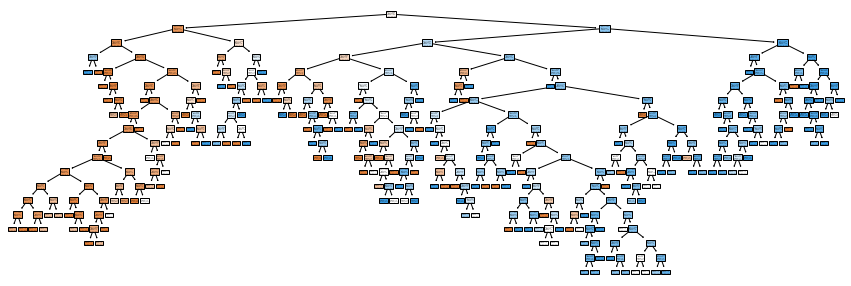

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,5))
plot_tree(tree, filled=True)
plt.show()

Meet de nauwkeurigheid van het resulterende decision tree met behulp van je testgegevens.

In [12]:
print(tree.score(X_test, y_test))

0.7740384615384616


Gebruik nu in plaats van een enkele trein / test-splitsing K-Fold cross validation om de nauwkeurigheid van je model beter te meten (K = 10). <br> 
Hint: gebruik `model_selection.cross_val_score`

In [13]:
from sklearn.model_selection import cross_val_score
import numpy as np
scores = cross_val_score(tree, X_test, y_test, cv=10)
print(np.mean(scores))

0.7154761904761905


Probeer nu een `RandomForestClassifier`. Presteert het beter?

In [14]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier().fit(X_train, y_train)
scores = cross_val_score(forest, X_test, y_test, cv=10)
print(np.mean(scores))

0.7697619047619048


## SVM

Probeer vervolgens `svm.SVC` te gebruiken met een lineaire kernel. Hoe verhoudt het zich tot de decision tree?

In [15]:
from sklearn.svm import SVC
svc = SVC(kernel='linear').fit(X_train, y_train)
scores = cross_val_score(svc, X_test, y_test, cv=10)
print(np.mean(scores))

0.8278571428571428


In [16]:
from sklearn.svm import LinearSVC
svc = LinearSVC().fit(X_train, y_train)
scores = cross_val_score(svc, X_test, y_test, cv=10)
print(np.mean(scores))

0.832857142857143


## KNN
Hoe zit het met K-Nearest-Neighbors? Hint: gebruik `neighbours.KNeighboursClassifier`. Begin met een K van 10. K is een voorbeeld van een hyperparameter - een parameter van het model zelf die mogelijk moet worden getuned voor de beste resultaten op basis van je specifieke dataset.

In [17]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)
scores = cross_val_score(knc, X_test, y_test, cv=10)
print(np.mean(scores))

0.7983333333333335


Het kiezen van K is lastig, dus we kunnen KNN niet weggooien voordat we verschillende waarden van K hebben geprobeerd. Schrijf een for-loop om KNN uit te voeren met K-waarden van 1 tot 50 en kijk of K een wezenlijk verschil maakt. Noteer de beste prestaties die je uit KNN kunt halen.

In [18]:
scores = []
for N in range(1,51):
    knc = KNeighborsClassifier(n_neighbors=N).fit(X_train, y_train)
    sc = cross_val_score(knc, X_test, y_test, cv=10)
    scores.append(np.mean(sc))
    
print(f"Optimal number of neighbors: {np.argmax(scores)}")

Optimal number of neighbors: 17


## Naive Bayes

Probeer nu `naive_bayes.MultinomialNB`. Hoe verloopt de nauwkeurigheid ervan? Hint: je moet eerst `MinMaxScaler` gebruiken om de features te krijgen in het bereik dat `MultinomialNB` vereist.

In [19]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(MinMaxScaler(), MultinomialNB()).fit(X_train, y_train)
print(pipe.score(X_test, y_test))

0.8173076923076923


## Terug naar SVM

`svm.SVC` kan anders presteren met verschillende kernels. De keuze van de kernel is een voorbeeld van een 'hyperparamter'. Probeer de `rbf`, `sigmoid` en `poly` kernels en kijk wat de best presterende kernel is. Hebben we een nieuwe winnaar?

In [20]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('rbf', 'sigmoid', 'poly')}
svc = SVC()
clf = GridSearchCV(svc, parameters).fit(X_train, y_train)
print(clf.best_score_)
print(clf.best_params_)

0.7861677419354839
{'kernel': 'rbf'}


## Logistic Regression

We hebben al deze mooie technieken geprobeerd, maar in wezen is dit slechts een binair classificatieprobleem. Probeer Logisitic Regression, dat is een eenvoudige manier om dit soort zaken aan te pakken.

In [21]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(X_train, y_train)
scores = cross_val_score(lr, X_test, y_test, cv=10)
print(np.mean(scores))

0.8276190476190475


## Hebben we een winnaar?

Welk model en welke keuze van hyperparameters presteerde het beste? Deel gerust jouw resultaten!

In [23]:
print(f"The winner is linear SVM")

The winner is linear SVM


De enige duidelijke verliezer zijn decision trees! Elk ander algoritme kan worden afgestemd om vergelijkbare resultaten te produceren met een nauwkeurigheid van 79-80%. Aanvullende afstemming van hyperparameters kunnen ook een verschil maken.